In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Data preparation

In [2]:
#Lets download the dataset
import nltk
from nltk.corpus import brown

In [3]:
corpus = brown.tagged_sents(tagset='universal')

In [4]:
corpus

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [5]:
len(corpus)

57340

In [6]:
corpus[0]  #Each element contains a sentence, and every word has its respective grammatical classification

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

In [7]:
#Lets get the tokens and the targets

inputs = []
targets = []

for sentence_pos_pair in corpus:
    token_list = []
    pos_list = []
    for token, pos in sentence_pos_pair:
        token_list.append(token)
        pos_list.append(pos)
    inputs.append(token_list)
    targets.append(pos_list)

In [8]:
inputs[0]

['The',
 'Fulton',
 'County',
 'Grand',
 'Jury',
 'said',
 'Friday',
 'an',
 'investigation',
 'of',
 "Atlanta's",
 'recent',
 'primary',
 'election',
 'produced',
 '``',
 'no',
 'evidence',
 "''",
 'that',
 'any',
 'irregularities',
 'took',
 'place',
 '.']

In [9]:
targets[0]

['DET',
 'NOUN',
 'NOUN',
 'ADJ',
 'NOUN',
 'VERB',
 'NOUN',
 'DET',
 'NOUN',
 'ADP',
 'NOUN',
 'ADJ',
 'NOUN',
 'NOUN',
 'VERB',
 '.',
 'DET',
 'NOUN',
 '.',
 'ADP',
 'DET',
 'NOUN',
 'VERB',
 'NOUN',
 '.']

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Bidirectional
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [11]:
#Split the data
train_inputs, test_inputs, train_targets, test_targets = train_test_split(
    inputs,
    targets,
    test_size=0.3,
)

In [12]:
#Convert sentences into sequences
word_tokenizer = Tokenizer(
    num_words = None, #We need to use everyword (Max_vocab = none)
    lower = False, #Bill != bill
    oov_token='UNK', #If we remove unknow words, len(inputs)!=len(targets)
)


word_tokenizer.fit_on_texts(train_inputs)
train_inputs_int = word_tokenizer.texts_to_sequences(train_inputs)
test_inputs_int = word_tokenizer.texts_to_sequences(test_inputs)

In [13]:
len(train_inputs_int)

40138

In [14]:
train_inputs[0]

['Four', 'for', 'Alvin']

In [15]:
train_inputs_int[0]

[3467, 15, 11966]

In [16]:
# word -> integer mapping
word2idx = word_tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 47309 unique tokens.


In [17]:
#define a flatten function for us to use
def flatten(list_list):
    flattened = [element for lists in list_list for element in lists]
    return flattened

In [18]:
train_targets_list = set(flatten(train_targets))
test_targets_list = set(flatten(test_targets))

In [19]:
train_targets_list

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [20]:
test_targets_list

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [21]:
test_targets_list == train_targets_list

True

In [22]:
#Now we need to transform the targets into sequences

#Convert sentences into sequences
word_tokenizer_targets = Tokenizer(
    num_words = None, #We need to use everyword (Max_vocab = none)
    lower = False, #Bill != bill
)
#We dont need to use OOV, because there is no unknow target

word_tokenizer_targets.fit_on_texts(train_targets)
train_targets_int = word_tokenizer_targets.texts_to_sequences(train_targets)
test_targets_int = word_tokenizer_targets.texts_to_sequences(test_targets)

In [23]:
train_targets_int[0]

[11, 4, 1]

In [24]:
train_targets[0]

['NUM', 'ADP', 'NOUN']

In [25]:
#Find the maximun lenght of the sequences
train_len = max(len(sequence) for sequence in train_inputs_int)
test_len = max(len(sequence) for sequence in test_inputs_int)
T = max((train_len,test_len))
T

180

In [26]:
#Pad_sequence Sentences

train_inputs_pad = pad_sequences(train_inputs_int, maxlen=T)
test_inputs_pad = pad_sequences(test_inputs_int, maxlen=T)

In [27]:
print(train_inputs_pad.shape)   #N x T  (number of samples x time)

(40138, 180)


In [28]:
print(test_inputs_pad.shape)

(17202, 180)


In [29]:
#Pad_sequence Targets

train_targets_pad = pad_sequences(train_targets_int, maxlen=T)
test_targets_pad = pad_sequences(test_targets_int, maxlen=T)

In [30]:
train_targets_pad.shape

(40138, 180)

In [31]:
#Number of classes
K = len(word_tokenizer_targets.word_index) +1  #Add 1 because the class 0 is already used for pad
K

13

In [32]:
V

47309

# Model

In [33]:
D = 32 #Embedding dimensionality

M = 32 #Number of hidden 'neurons'

i = Input(shape = (T,))
x = Embedding(V+1, D, mask_zero = True)(i) #We need to use mask_zero, because in our dataset we added targets = 0 in padding elements. We don't want to use these values to calculate the loss
x = Bidirectional(LSTM(M, return_sequences = True))(x)
x = Dense(K)(x) #Last layer -> LSTM --> logits

model = Model(i,x)

In [34]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 180, 32)   │  1,513,920 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 180)       │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 180, 64)   │     16,640 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 180, 13)   │        845 │ bidirectional[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,531,405 (5.84 MB)

 Trainable params: 1,531,405 (5.84 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
len(model.layers[2].get_weights())

6

In [36]:
a,b,c,d,e,f = model.layers[2].get_weights()
print(a.shape, b.shape, c.shape, d.shape, e.shape, f.shape)

#Shapes:
# Wxi,Wxo,Wxf,Wxc   --> input_size, 4*output
# Whi, Who, Whf, Whc --> output, 4*output

#a,b,c -> one direction // d,e,f -> opposite direction

(32, 128) (32, 128) (128,) (32, 128) (32, 128) (128,)


In [37]:
# Compile and fit
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)

# NOTE: you "could" speed this up by creating a custom loss, since Tensorflow's
# implementation of mask_zero currently sucks, but it's sufficiently advanced
# to be outside the scope of this course
# In my experiments, CPU is faster than GPU in all cases, and CPU for custom
# loss is faster than CPU for mask_zero

# > 300-400s per epoch on CPU
# > 30 MINUTES per epoch on GPU
r = model.fit(
  train_inputs_pad,
  train_targets_pad,
  epochs=5,
  validation_data=(test_inputs_pad, test_targets_pad)
)

Epoch 1/5
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 144s 111ms/step - accuracy: 0.0845 - loss: 0.9462 - val_accuracy: 0.1095 - val_loss: 0.1099
Epoch 2/5
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 138s 110ms/step - accuracy: 0.1100 - loss: 0.0747 - val_accuracy: 0.1101 - val_loss: 0.0879
Epoch 3/5
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 138s 110ms/step - accuracy: 0.1111 - loss: 0.0442 - val_accuracy: 0.1102 - val_loss: 0.0855
Epoch 4/5
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 142s 110ms/step - accuracy: 0.1109 - loss: 0.0324 - val_accuracy: 0.1101 - val_loss: 0.0894
Epoch 5/5
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 138s 110ms/step - accuracy: 0.1116 - loss: 0.0254 - val_accuracy: 0.1102 - val_loss: 0.0939


## Model evaluation

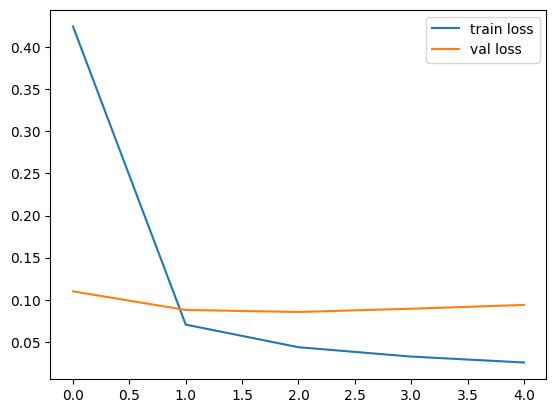

In [38]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

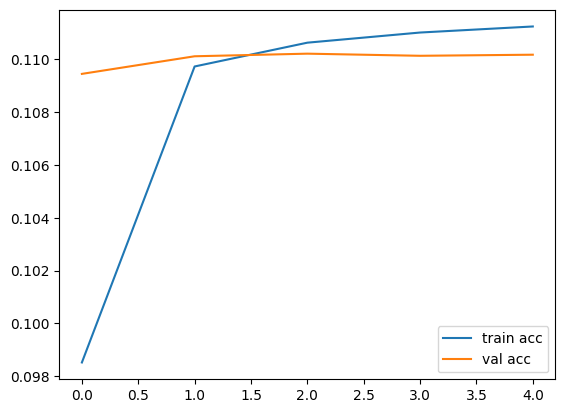

In [39]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [40]:
# True model accuracy:
# The previous accuracy used the targets of the padding too. So, we need to account for only the true predictions.

# first get length of each sequence
train_lengths = []
for sentence in train_inputs:
  train_lengths.append(len(sentence))

test_lengths = []
for sentence in test_inputs:
  test_lengths.append(len(sentence))

print(f"Train lengths: {len(train_lengths)}\nTest lengths: {len(test_lengths)} ")

Train lengths: 40138
Test lengths: 17202 


In [41]:
train_probs = model.predict(train_inputs_pad)
train_predictions = []



1255/1255 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step


In [42]:
train_probs.shape  #N x T x K

for probs, length in zip(train_probs, train_lengths):
    
    probs_ = probs[-length:] #The first tokens are for padding
    preds = np.argmax(probs_, axis=1)
    train_predictions.append(preds)
    

true_targets_train = flatten(train_targets_int)
predictions_targets_train = flatten(train_predictions)

In [43]:
test_probs = model.predict(test_inputs_pad)
test_predictions = []

for probs, length in zip(test_probs, test_lengths):
    
    probs_ = probs[-length:] #The first tokens are for padding
    preds = np.argmax(probs_, axis=1)
    test_predictions.append(preds)
    

true_targets_test = flatten(test_targets_int)
predictions_targets_test = flatten(test_predictions)

538/538 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step


In [44]:
from sklearn.metrics import accuracy_score, f1_score

print("Train acc:", accuracy_score(true_targets_train, predictions_targets_train))
print("Test acc:", accuracy_score(true_targets_test, predictions_targets_test))

print("Train f1:",
      f1_score(true_targets_train, predictions_targets_train, average='macro'))
print("Test f1:",
      f1_score(true_targets_test, predictions_targets_test, average='macro'))

Train acc: 0.9942594973728439
Test acc: 0.9724836806248397
Train f1: 0.9883117019983336
Test f1: 0.9358405129186181


## Comparing the model against a baseline model (word POS map)

In [45]:
## Baseline model: map word to tag
from collections import Counter

# https://stackoverflow.com/questions/1518522/find-the-most-common-element-in-a-list
def most_common(lst):
  data = Counter(lst)
  return data.most_common(1)[0][0]

In [46]:
token2tags = {k: [] for k, v in word2idx.items()}

# remove UNK token
del token2tags['UNK']

for tokens, tags in zip(train_inputs, train_targets):
  for token, tag in zip(tokens, tags):
    if token in token2tags:
      token2tags[token].append(tag) #for each word, lets append every tag that appears

token2tag = {k: most_common(v) for k, v in token2tags.items()}

In [47]:
# compute accuracy

train_predictions = []
for sentence in train_inputs:
  predictions = []
  for token in sentence:
        
    predicted_tag = token2tag[token]
    predictions.append(predicted_tag)
  train_predictions.append(predictions)
flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(train_targets)

In [48]:
test_predictions = []
for sentence in test_inputs:
  predictions = []
  for token in sentence:
    predicted_tag = token2tag.get(token, 'INCORRECT')
    predictions.append(predicted_tag)
  test_predictions.append(predictions)
flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(test_targets)

In [49]:
print("Train acc:", accuracy_score(flat_train_targets, flat_train_predictions))
print("Test acc:", accuracy_score(flat_test_targets, flat_test_predictions))

print("Train f1:",
      f1_score(flat_train_targets, flat_train_predictions, average='macro'))
print("Test f1:",
      f1_score(flat_test_targets, flat_test_predictions, average='macro'))

Train acc: 0.9576224545954871
Test acc: 0.9266868105242154
Train f1: 0.9402645530935039
Test f1: 0.8272883979511254


## Summary
- We used a Bidimensional LSTM architecture to predict the part of speech.
- Our model outperformed the baseline, even with a good performance on this model.